In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import json

from readImages import *
from imageModifiers import *
from readDataFiles import *
from projEdgeBreaks import *
from gaussBreaks import *
from saveImages import *
from plottingFuncs import *

mpl.rcParams["figure.figsize"] = (15, 15)

In [2]:
subjFile = "data/anti-slavery-manuscripts-subjects.csv"
subj = pd.read_csv(subjFile)

# get metadata in dictionary format
subj["meta_json"] = [json.loads(q) for q in subj["metadata"]]

# get image url
subj["url"] = [json.loads(q).get("0") for q in subj["locations"]]

# get beta images
subj_beta = subj.loc[subj["subject_set_id"] == 16228]
len(subj_beta)

60

In [4]:
# read in and do all pre-processing #################################
let_orig, grey_orig = readImg(subj_beta["url"].iloc[10])
grey, let, offset = removeEdges(grey_orig, let_orig, 10.0)
greySm = smoothImg(grey, 7.0)

In [ ]:
greySm = smoothImg(grey, [2.0, 8.0])
greyBi = binarizeImg(greySm, threshFn=skimfilt.threshold_otsu)[0]

plt.imshow(greyBi, cmap="gray")
plt.show()

In [ ]:
plt.imshow(let_orig)
plt.show()

plt.imshow(let)
plt.show()

plt.imshow(greySm, cmap="gray")
plt.show()

In [5]:
# get linebreaks ####################################################
matchlim = 30
lb = projBreaks(greySm, "y")
lb = filterBreaks(lb, matchlim)
plotBoxes(let, lb, saveFile="example_img/linebreaks.png")

In [6]:
# get wordbreaks ####################################################
# accur = wordBreaks(grey, lb, matches, linesForTele)
wb = []
nu = 3.5
biThresh = 2
for i in range(1, len(lb)):
    chunk = grey[lb[i-1]:lb[i],]
#     chunkSm = smoothImg(chunk, 8.0)
#     chunkSmBi = binarizeImg(chunkSm, threshFn=skimfilt.threshold_otsu, plotIt=True)
#     br = projBreaks(chunkSmBi, "x")
    print(i, end=" ")
    br = gaussBreaks(chunk, nu=nu, biThresh=biThresh, shear=0, fix=0,
                     plotIt=False, threshFn=skimfilt.threshold_otsu)
    wb.append(br)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

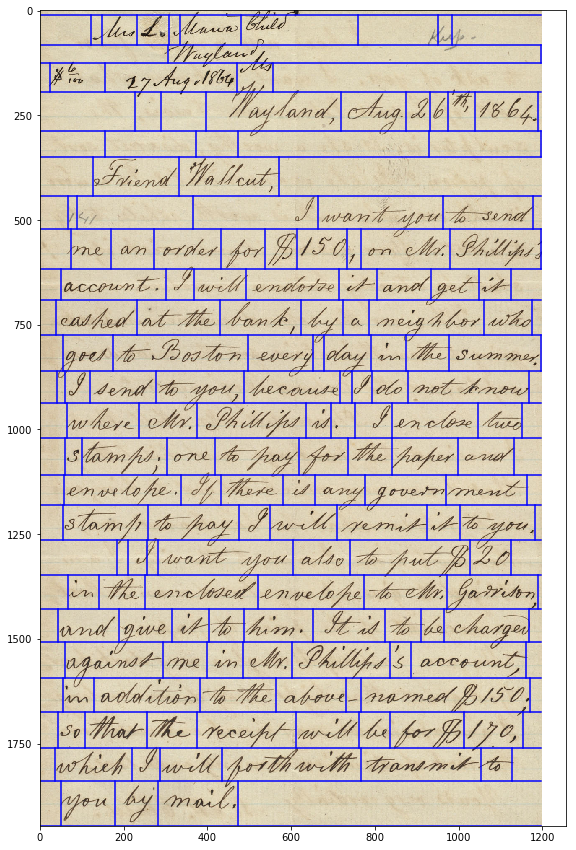

In [7]:
plotBoxes(let, lb, wb)#, saveFile="example_img/wordbreaks.png")

# Gaussian breaks

In [ ]:
import numpy as np
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter as gf
from skimage import transform as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle as Rec
from skimage import filters as skimfilt
from imageModifiers import *

In [ ]:
i = 6
chunk = grey[lb[i-1]:lb[i],]
plt.imshow(chunk, cmap="gray")
plt.show()

nu = 4
biThresh = 3
shear=0
fix=0
order=0
plotIt=True

# def gaussBreaks(chunk, nu=3.5, biThresh=2, shear=0.6, fix=15, order=0, plotIt=False):

In [ ]:
# get smoothing factors
sigYs = np.arange(1, 8, 0.3)
sigXs = sigYs * nu
# shear the image
oldrg = (np.max(chunk) - np.min(chunk))
newrg = 2
ch2 = (((chunk - np.min(chunk)) * newrg) / oldrg) - 1
mytf = tf.AffineTransform(shear=shear)
chunk = tf.warp(ch2, inverse_map=mytf)

In [ ]:
# choose which smoothing factor to use based on minimizing
# the white space
extents = []
count = 0
for j in range(len(sigYs)):
    filt = gf(input=chunk, sigma=(sigYs[j],sigXs[j]), order=order)
    if count < biThresh:
        binfilt, th = binarizeImg(filt, skimfilt.threshold_otsu)
        count += 1
    else:
        binfilt, _ = binarizeImg(filt, biThresh=th)
    extents.append(np.sum(binfilt))
j = np.argmin(extents)

filt = gf(input=chunk, sigma=(sigYs[j],sigXs[j]))
binfilt, _ = binarizeImg(filt, biThresh=th)
binfilt = 1 - binfilt

# find connect components
labels, nrObj = ndimage.label(binfilt)
osli = ndimage.find_objects(labels)

# find the word boxes
rec = []
bounds = []
sh = np.max(labels.shape)
for sl in osli:
    sl0 = sl[0].indices(sh)
    sl1 = sl[1].indices(sh)

    xLeng = sl1[1]-sl1[0]
    yLeng = sl0[1]-sl0[0]
    if xLeng*yLeng > 100:
        bounds.append([sl1[0], sl1[1]])
        rec.append([[sl1[0], sl0[0]], xLeng, yLeng])

In [ ]:
# combine those that are surrounded by others
bounds = sorted(bounds)

In [ ]:
bounds

In [ ]:
newbounds = []
skipnext = False
if len(bounds) <= 0:
    pass#return [0, chunk.shape[1]]
bPrev = bounds[0]
for i in range(1, len(bounds)):
    bCur = bounds[i]
    if bPrev[1] > bCur[0]:
        bPrev = [bPrev[0], max(bCur[1], bPrev[1])]
    else:
        newbounds.append(bPrev)
        bPrev = [x for x in bCur]
newbounds.append(bPrev)

In [ ]:
newbounds

In [ ]:
try:
    wbLine = [newbounds[0][0]]
except:
    wbLine = [0]
for i in range(1, len(newbounds)):
    b1 = newbounds[i-1]
    b2 = newbounds[i]
    wbLine.append(np.mean([b1[1], b2[0]])-fix)
try:
    wbLine.append(b2[1])
except:
    wbLine.append(chunk.shape[1])
#         pass

In [ ]:
# plot connected components
if plotIt:
    fit,ax = plt.subplots(1)
    ax.imshow(labels, cmap='nipy_spectral')
    for i in range(len(rec)):
        rect = mpl.patches.Rectangle(rec[i][0], rec[i][1], rec[i][2], linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
    plt.show()

# return np.array(wbLine).astype("int")